Если вы запускаете данный ноутбук в коллабе с gpu, то выполните следующую ячейку для правильной установки зависимостей

In [1]:
import torch

def format_pytorch_version(version):
    return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
    return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install -q torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-geometric
!pip install -q sentence-transformers==2.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.6/886.6 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 14.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 79.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 89.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [60]:
# расскоментируйте код ниже, чтобы установить все зависимости
# !pip install \
#     pyarrow==12.0.1 \
#     polars==0.18.6 \
#     tqdm==4.65.0 \
#     scipy==1.10.1 \
#     scikit-learn==1.3.0 \
#     numpy==1.24.3 \
#     torch==2.0.1 \
#     torch-scatter==2.1.1 \
#     torch-sparse==0.6.17 \
#     torch-cluster==1.6.1 \
#     torch-geometric==2.3.1 \
#     sentence-transformers==2.2.2

In [1]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.datasets import Planetoid, MovieLens
from torch_geometric.nn import Node2Vec, SAGEConv, LightGCN, to_hetero
from torch_geometric.data import Data, HeteroData
from torch_geometric.utils import degree
import torch_geometric.transforms as T

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm


# будем использовать cuda, если доступны вычисления на gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

device: cuda


Мы будем использовать библиотеку `pytorch-geometric`, которая позволяет работать с графовыми структурами данных и предоставляет готовые алгоритмы графовых нейросетей

В качестве структуры данных есть два класса: _Data_ и _HeteroData_

In [3]:
# матрица смежности (пара номеров вершин u и v, между которыми проведены ребра)
edge_index = torch.tensor([[0, 1],
                           [1, 2]], dtype=torch.long)
# в вершины можно записать разные значения, например числа
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.T.contiguous())
# сделаем наши ребра ненаправленные
data = T.ToUndirected()(data)
data.validate(raise_on_error=True)

data.x, data.edge_index

(tensor([[-1.],
         [ 0.],
         [ 1.]]),
 tensor([[0, 1, 1, 2],
         [1, 0, 2, 1]]))

![image](https://pytorch-geometric.readthedocs.io/en/latest/_images/graph.svg)

In [4]:
data = HeteroData().to(device)

n_edges = 1_000
num_papers = 100
num_authors = 500

num_paper_features = num_authors_features = 32

# создадим два типа вершин: paper и author с матрицой признаков
data['paper'].x = torch.randn(num_papers, num_paper_features)
data['author'].x = torch.randn(num_authors, num_authors_features)

# отношение author написал paper сохраним в виде матрицы смежности
data['author', 'writes', 'paper'].edge_index = torch.vstack([
    torch.randint(0, num_papers, (n_edges, ), device=device),
    torch.randint(0, num_authors, (n_edges, ), device=device),
])
# добавим обратные ребра в граф
data = T.ToUndirected()(data)

data

HeteroData(
  paper={ x=[100, 32] },
  author={ x=[500, 32] },
  (author, writes, paper)={ edge_index=[2, 1000] },
  (paper, rev_writes, author)={ edge_index=[2, 1000] }
)

## Node2vec

Node2Vec является вариацией случайного блуждания с параметрами `p` и `q` для контроля глубины блуждания

В данном примере мы рассмотрим датасет [Cora](https://paperswithcode.com/dataset/cora), где представлен граф цитирований статей

![](https://production-media.paperswithcode.com/datasets/Cora-0000000700-ce1c5ec7_LD7pZnT.jpg)

In [5]:
dataset = Planetoid('.', name='Cora')
data = dataset[0]
data

Processing...
Done!


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [6]:
# 2708 различных статей
# каждая представлена в виде вектора с мешком слов (1433 уникальных)
data.x.shape

torch.Size([2708, 1433])

Epoch: 010, Loss: 4.0991, Acc: 0.2120
Epoch: 020, Loss: 2.2215, Acc: 0.3550
Epoch: 030, Loss: 1.4466, Acc: 0.4570
Epoch: 040, Loss: 1.1210, Acc: 0.5430
Epoch: 050, Loss: 0.9826, Acc: 0.5900
Epoch: 060, Loss: 0.9194, Acc: 0.6370
Epoch: 070, Loss: 0.8851, Acc: 0.6570
Epoch: 080, Loss: 0.8655, Acc: 0.6650
Epoch: 090, Loss: 0.8541, Acc: 0.6850
Epoch: 100, Loss: 0.8432, Acc: 0.6900


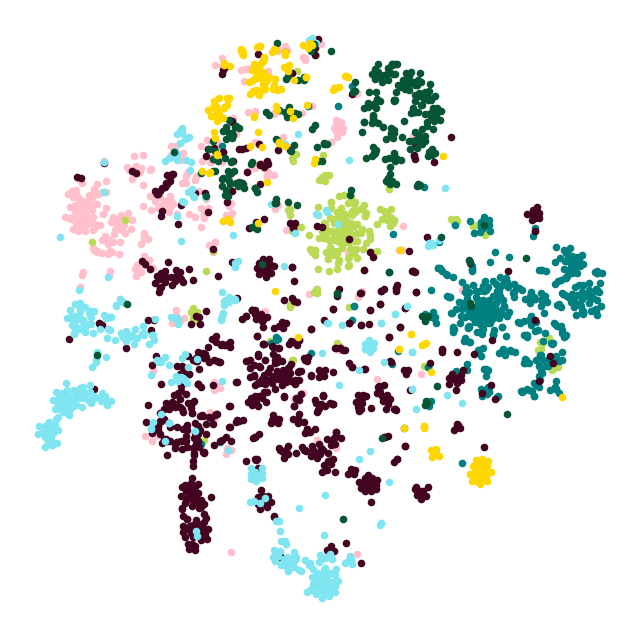

In [7]:
model = Node2Vec(
    data.edge_index,
    embedding_dim=128,  # размер эмбеддинга вершины
    walk_length=20,  # длина случайного блуждания
    context_size=10,  # размер окна из случайного блуждания (как в w2v)
    walks_per_node=10,  # количество случайных блужданий из одной вершины
    num_negative_samples=1,  # количество негативных примеров на один позитивный
    p=1.0,  # параметр вероятности вернуться в предыдущую вершину
    q=1.0,  # параметр вероятности исследовать граф вглубь
    sparse=True,
).to(device)

# класс Node2Vec предоставляет сразу генератор случайного блуждания
loader = model.loader(batch_size=512, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)


def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        # pos_rw – последовательность из случайного блуждания
        # neg_rw – случайные негативные примеры
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(
        train_z=z[data.train_mask],
        train_y=data.y[data.train_mask],
        test_z=z[data.test_mask],
        test_y=data.y[data.test_mask],
        max_iter=150,
    )
    return acc


for epoch in range(1, 101):
    loss = train()
    acc = test()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Acc: {acc:.4f}')


@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model().cpu().numpy()
    z = TSNE(n_components=2).fit_transform(z)
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()


colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]
plot_points(colors)

## SAGE

В данном примере мы рассмотрим подход [GraphSAGE](https://paperswithcode.com/method/graphsage) на примере датасета Movielens

![](https://production-media.paperswithcode.com/methods/1b38ceba-a031-474f-a39f-26abc1735e0b.png)

In [8]:
dataset = MovieLens('.', model_name='all-MiniLM-L6-v2')
data = dataset[0].to(device)

Extracting ./raw/ml-latest-small.zip
Processing...


Batches:   0%|          | 0/305 [00:00<?, ?it/s]

Done!


In [9]:
# в качестве признаков вершины используем one-hot вектор
data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes

# добавим обратные ребра, чтобы путь в графе мог быть как user -> item, так и item -> user
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label

In [10]:
data

HeteroData(
  movie={ x=[9742, 404] },
  user={ x=[610, 610] },
  (user, rates, movie)={
    edge_index=[2, 100836],
    edge_label=[100836]
  },
  (movie, rev_rates, user)={ edge_index=[2, 100836] }
)

In [11]:
use_weighted_loss = True

# в качестве валидации для графов будем случайно выбирать ребра между вершинами
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)

# в датасете много оценок 3 и 4 и мало 0 и 1, поэтому воспользуемся взвешенным
# MSE в качетсве фукнции ошибки
if use_weighted_loss:
    weight = torch.bincount(train_data['user', 'movie'].edge_label)
    weight = weight.max() / weight
else:
    weight = None


def weighted_mse_loss(pred, target, weight=None):
    weight = 1. if weight is None else weight[target].to(pred.dtype)
    return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()

In [12]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

In [13]:
model = Model(hidden_channels=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


def train():
    model.train()
    optimizer.zero_grad()
    pred = model(
        train_data.x_dict,
        train_data.edge_index_dict,
        train_data['user', 'movie'].edge_label_index
    )
    target = train_data['user', 'movie'].edge_label
    loss = weighted_mse_loss(pred, target, weight)
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)


for epoch in range(1, 301):
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
            f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')

Epoch: 010, Loss: 7.8644, Train: 2.1796, Val: 2.1957, Test: 2.1888
Epoch: 020, Loss: 5.6293, Train: 1.2752, Val: 1.2969, Test: 1.2914
Epoch: 030, Loss: 5.0650, Train: 1.0295, Val: 1.0515, Test: 1.0445
Epoch: 040, Loss: 4.0243, Train: 1.0586, Val: 1.0806, Test: 1.0708
Epoch: 050, Loss: 3.6287, Train: 1.1465, Val: 1.1669, Test: 1.1556
Epoch: 060, Loss: 3.4773, Train: 1.1471, Val: 1.1721, Test: 1.1634
Epoch: 070, Loss: 3.3226, Train: 1.1364, Val: 1.1675, Test: 1.1604
Epoch: 080, Loss: 3.2212, Train: 1.1263, Val: 1.1637, Test: 1.1553
Epoch: 090, Loss: 3.1278, Train: 1.1092, Val: 1.1533, Test: 1.1439
Epoch: 100, Loss: 3.0535, Train: 1.1076, Val: 1.1559, Test: 1.1478
Epoch: 110, Loss: 2.9951, Train: 1.1013, Val: 1.1534, Test: 1.1469
Epoch: 120, Loss: 2.9457, Train: 1.0995, Val: 1.1550, Test: 1.1473
Epoch: 130, Loss: 2.9030, Train: 1.0932, Val: 1.1509, Test: 1.1409
Epoch: 140, Loss: 2.8644, Train: 1.0926, Val: 1.1523, Test: 1.1404
Epoch: 150, Loss: 2.8269, Train: 1.0819, Val: 1.1444, Test: 1.